### Dataset: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset?resource=download
### Tutorial: https://www.youtube.com/watch?v=V_xro1bcAuA&t=77134s

In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [35]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import random
import os
torch.__version__

'2.2.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [4]:
!nvidia-smi

Fri Mar 15 16:30:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 41%   46C    P0            108W /  400W |     578MiB /  12288MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
IMAGE_PATH = "./data/melanoma"

In [6]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'")

walk_through_dir("./data")

There are 1 directories and 0 images in './data'
There are 2 directories and 0 images in './data/melanoma'
There are 2 directories and 0 images in './data/melanoma/train'
There are 0 directories and 100 images in './data/melanoma/train/Benign'
There are 0 directories and 100 images in './data/melanoma/train/Malignant'
There are 2 directories and 0 images in './data/melanoma/test'
There are 0 directories and 100 images in './data/melanoma/test/Benign'
There are 0 directories and 100 images in './data/melanoma/test/Malignant'


In [7]:
image_dir = Path("./data/melanoma")
train_dir = Path("./data/melanoma/train")
test_dir = Path("./data/melanoma/test")

Random image path: data/melanoma/test/Malignant/6211.jpg
Image class is: Malignant
Image width: 224
Image height: 224


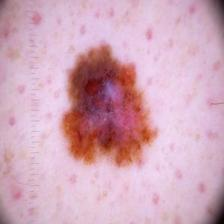

In [8]:
image_path_list = list(image_dir.glob("*/*/*.jpg"))
rand_image_path = random.choice(image_path_list)
image_class = rand_image_path.parent.stem
img = Image.open(rand_image_path)
print(f"Random image path: {rand_image_path}")
print(f"Image class is: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 223.5, 223.5, -0.5)

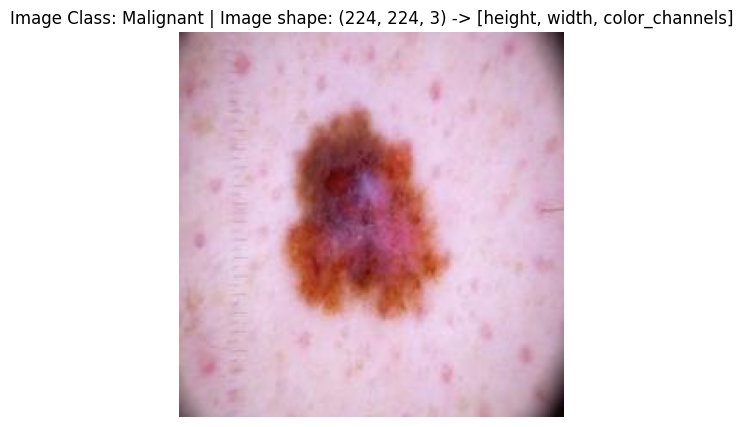

In [9]:
img_as_array = np.asarray(img)

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [10]:
img_as_array

array([[[ 91,  59,  70],
        [ 94,  62,  73],
        [101,  68,  79],
        ...,
        [ 46,  26,  35],
        [ 38,  21,  29],
        [ 34,  17,  25]],

       [[ 95,  63,  74],
        [ 98,  66,  77],
        [105,  72,  83],
        ...,
        [ 49,  29,  38],
        [ 41,  24,  32],
        [ 36,  19,  27]],

       [[101,  69,  80],
        [105,  73,  84],
        [111,  78,  89],
        ...,
        [ 53,  33,  42],
        [ 44,  27,  35],
        [ 40,  23,  31]],

       ...,

       [[105,  82,  90],
        [109,  86,  94],
        [116,  93, 101],
        ...,
        [ 16,   8,   6],
        [ 14,   6,   4],
        [ 12,   4,   2]],

       [[100,  79,  86],
        [104,  83,  90],
        [111,  88,  96],
        ...,
        [ 14,   6,   4],
        [ 14,   6,   3],
        [ 11,   6,   2]],

       [[ 98,  77,  84],
        [101,  80,  87],
        [107,  84,  92],
        ...,
        [ 13,   5,   3],
        [ 11,   6,   2],
        [ 11,   6,   2]]

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 128, 128])

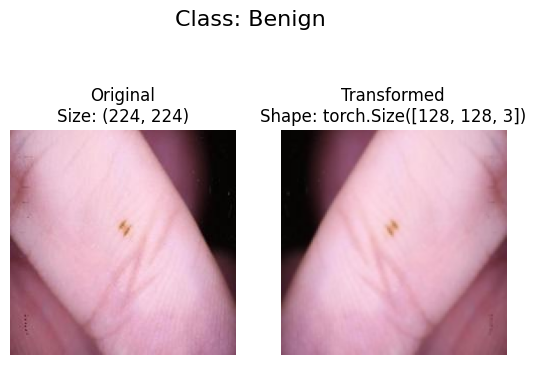

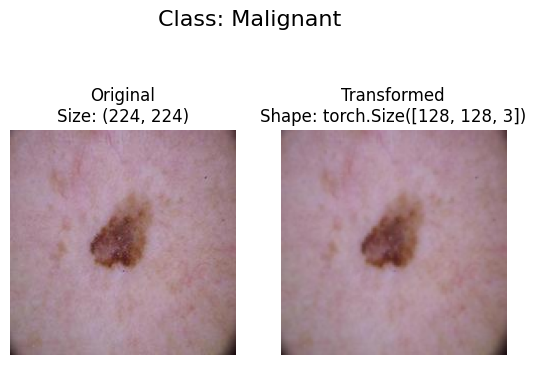

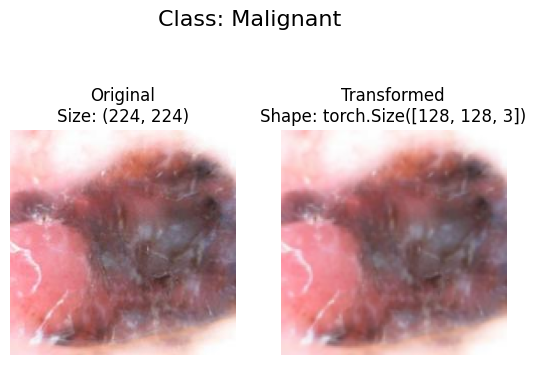

In [13]:
def plot_transformed_images(image_paths, transform, n=3):
    rand_image_paths = random.sample(image_paths, k=n)
    for image_path in rand_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3)

In [14]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/melanoma/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/melanoma/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
classes = train_data.classes
classes

['Benign', 'Malignant']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'Benign': 0, 'Malignant': 1}

In [17]:
len(train_data), len(test_data)

(200, 200)

In [19]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data/melanoma/train


['Benign', 'Malignant']

In [25]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Counld not find the classes. Check the directory: {directory}")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

print(find_classes(train_dir))

(['Benign', 'Malignant'], {'Benign': 0, 'Malignant': 1})


In [48]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [71]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

In [72]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)


train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ff0c04bfc70>,
 <__main__.ImageFolderCustom at 0x7ff0c04bf100>)

In [73]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True):
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(20,20))
    for i, targ_smaple in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_smaple][0], dataset[targ_smaple][1] 
        targ_image_adjust = targ_image.permute(1,2,0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes: 
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

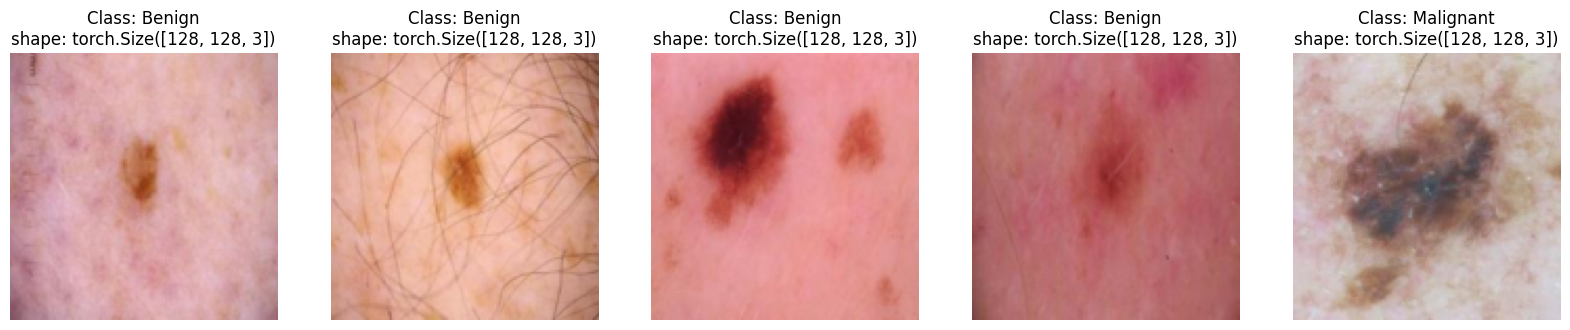

In [74]:
display_random_images(train_data,
                      n=5,
                      classes=train_data.classes)

In [75]:
BATCH_SIZE=32
train_data_loader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=0,
                                      shuffle=True)

test_data_loader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

In [76]:
img_custom, label_custom = next(iter(train_data_loader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [77]:
image_path_list

[PosixPath('data/melanoma/train/Benign/1250.jpg'),
 PosixPath('data/melanoma/train/Benign/1707.jpg'),
 PosixPath('data/melanoma/train/Benign/2719.jpg'),
 PosixPath('data/melanoma/train/Benign/3983.jpg'),
 PosixPath('data/melanoma/train/Benign/3968.jpg'),
 PosixPath('data/melanoma/train/Benign/1229.jpg'),
 PosixPath('data/melanoma/train/Benign/3351.jpg'),
 PosixPath('data/melanoma/train/Benign/3447.jpg'),
 PosixPath('data/melanoma/train/Benign/2461.jpg'),
 PosixPath('data/melanoma/train/Benign/2545.jpg'),
 PosixPath('data/melanoma/train/Benign/1696.jpg'),
 PosixPath('data/melanoma/train/Benign/5301.jpg'),
 PosixPath('data/melanoma/train/Benign/1061.jpg'),
 PosixPath('data/melanoma/train/Benign/5076.jpg'),
 PosixPath('data/melanoma/train/Benign/4328.jpg'),
 PosixPath('data/melanoma/train/Benign/4941.jpg'),
 PosixPath('data/melanoma/train/Benign/4752.jpg'),
 PosixPath('data/melanoma/train/Benign/2757.jpg'),
 PosixPath('data/melanoma/train/Benign/4440.jpg'),
 PosixPath('data/melanoma/train

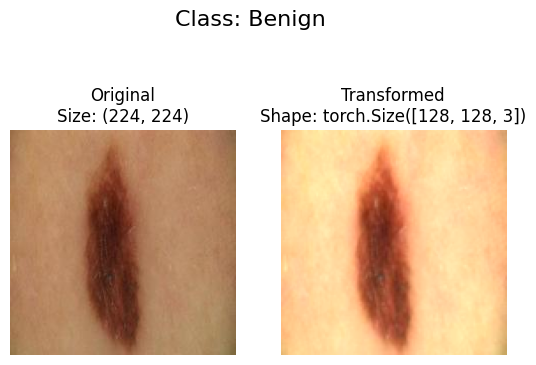

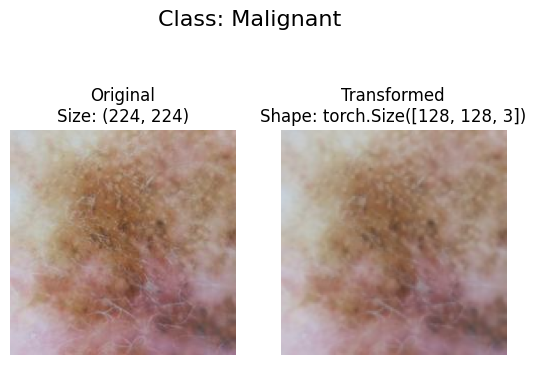

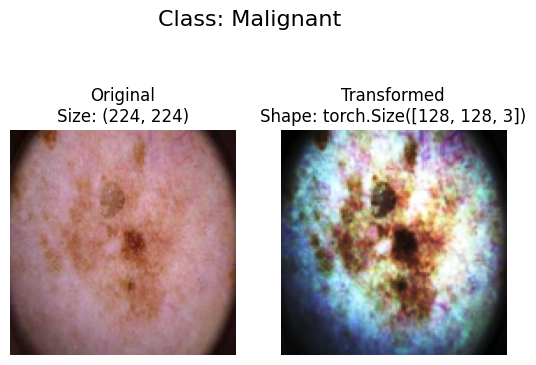

In [84]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=3)